# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from maddpg import MADDPG
from params import *
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
def plot_scores(scores):
    # Compute rolling average
    average_scores = [np.mean(scores[i-100:i]) for i in range(len(scores))]

    # Plot 
    fig = plt.figure()
    plt.plot(scores, color='b', label='Score')
    plt.plot(average_scores, color='r', label='Average Score')
    plt.plot(np.ones(len(scores))*0.5, linestyle='dashed', color='y', label='Target')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend()

    plt.show()


In [6]:
def ddpg(maddpg, total_scores, print_every=100, save_every=500):
    """ Deep Deterministic Policy Gradients (DDPG) for multiple agents.
        
        Params
        ======
        maddpg (MADDPG): an object encapsulating multiple agents to be trained
        total_scores (list(float)): empty list to hold scores per episode
        print_every (int): print training stats every 'print_every' episodes
        save_every (int): save checkpoint every 'save_every' episodes

        Returns
        ======
        total_scores (list(float)): a list containing the max score over both agent for each episode

    """

    max_score = TARGET_SCORE

    for i_episode in range(1, N_EPISODES+1):
        env_info = env.reset(train_mode=True)[brain_name]                           # reset the environment    
        maddpg.reset()
        states = env_info.vector_observations                                       # get the current state (for each agent)
        scores = np.zeros(num_agents)                                               # initialize the score (for each agent)

        t = 1
        while t <= N_TIMESTEPS_PER_EPISODE:                                                   
            actions = maddpg.act(states, add_noise=True, noise_decay=NOISE_DECAY)   # select an action (for each agent)
            env_info = env.step(actions)[brain_name]                                # send all actions to tne environment
            next_states = env_info.vector_observations                              # get next state (for each agent)
            rewards = env_info.rewards                                              # get reward (for each agent)
            dones = env_info.local_done                                             # see if episode finished
            
            # add experiences of both agents to a shared replay buffer
            maddpg.add_to_buffer(states, actions, rewards, next_states, dones)

            # learn
            if i_episode >= WAIT_UNTIL_TRAINING and t % TRAIN_EVERY == 0:
                for _ in range(REPEAT_TRAINING):
                    maddpg.train()

            scores += rewards                                                       # update the score (for each agent)
            states = next_states                                                    # roll over states to next time step
            t += 1
            
            if np.any(dones):                                                       # exit loop if episode finished
                break

        total_scores.append(np.max(scores))
        average_score = np.mean(total_scores[-100:])

        # print training stats
        if i_episode%print_every==0:            
            print('\nEpisode {:d}:\tAverage Score: {:.2f}\tScore: {:.2f}\tMin: {:.2f}\tMax: {:.2f}'.format(\
                i_episode, average_score,  np.max(scores), np.min(total_scores[-print_every:]), np.max(total_scores[-print_every:])))

        # save networks
        if i_episode%save_every==0:
            maddpg.save(dir='ckpts/', identifier='_episode_{:d}'.format(i_episode))
            print('\nEpisode: {:d}: Networks saved'.format(i_episode))

        # save final networks when target performance reached
        if i_episode >= 100 and average_score > max_score:
            print('\nFinished! Environment solved in {:d} episodes with an average score of {:.2f} over the last 100 episodes!'.format(i_episode, average_score))
            print('\nSaving networks...')
            maddpg.save(dir='', identifier='_final_{:d}'.format(i_episode))
            print('\nDone!')
            max_score = average_score

    return total_scores


In [8]:

# create an MADDPG object which encapsulates two agents (one for each racket)
maddpg = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)

# initialize an empty list that holds the score for every episode
scores = []

# start training (hyperparamaters are stored in params.py)
ddpg(maddpg, scores, print_every=100, save_every=1000)

c:\Users\sebas\OneDrive\Documents\repos\drl-p3-collab-compet\ddpg_agent.py:108: UserWarning: Using a target size (torch.Size([256, 2])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(Q_expected, Q_targets)



Episode 100:	Average Score: -0.00	Score: -0.00	Min: -0.00	Max: 0.05

Episode 200:	Average Score: 0.00	Score: -0.00	Min: -0.00	Max: 0.10

Episode 300:	Average Score: -0.00	Score: -0.00	Min: -0.00	Max: 0.05

Episode 400:	Average Score: -0.00	Score: -0.00	Min: -0.00	Max: 0.10

Episode 500:	Average Score: 0.01	Score: -0.00	Min: -0.00	Max: 0.10

Episode 600:	Average Score: 0.01	Score: -0.00	Min: -0.00	Max: 0.20

Episode 700:	Average Score: 0.01	Score: 0.10	Min: -0.00	Max: 0.20

Episode 800:	Average Score: 0.03	Score: 0.05	Min: -0.00	Max: 0.25

Episode 900:	Average Score: 0.03	Score: -0.00	Min: -0.00	Max: 0.25

Episode 1000:	Average Score: 0.04	Score: 0.10	Min: -0.00	Max: 0.30

Episode: 1000: Networks saved

Episode 1100:	Average Score: 0.11	Score: 0.05	Min: -0.00	Max: 0.50

Episode 1200:	Average Score: 0.30	Score: 0.10	Min: -0.00	Max: 2.60

Episode 1300:	Average Score: 0.33	Score: 0.20	Min: -0.00	Max: 2.60

Episode 1400:	Average Score: 0.39	Score: 0.10	Min: -0.00	Max: 2.55

Finished! Envir

### 4. Results

#### 4.1 Plot Scores

c:\Users\sebas\anaconda3\envs\drlnd\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\sebas\anaconda3\envs\drlnd\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


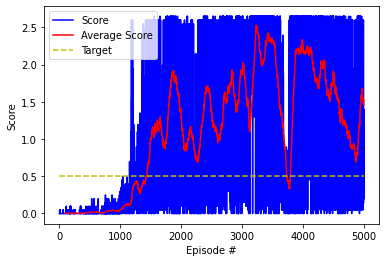

In [9]:
plot_scores(scores)

#### 4.2 Plot Noise Decay

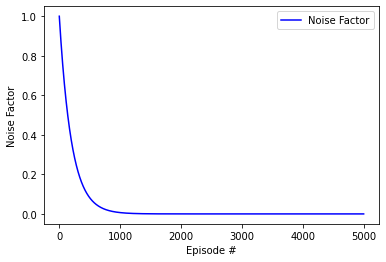

In [12]:

fig = plt.figure()
plt.plot([pow(NOISE_DECAY, i)  for i in range(len(scores))], color='b', label='Noise Factor')
plt.ylabel('Noise Factor')
plt.xlabel('Episode #')
plt.legend()

plt.show()

#### 4.3 Interact with the environment

In [7]:
# create an MADDPG object which encapsulates two agents (one for each racket)
maddpg = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)

# restore saved checkpoints
maddpg.load(agent_0_actor='checkpoint_agent_0_actor_final_3232.pth', \
            agent_0_critic='checkpoint_agent_0_critic_final_3232.pth', \
            agent_1_actor='checkpoint_agent_1_actor_final_3232.pth', \
            agent_1_critic='checkpoint_agent_1_critic_final_3232.pth')

In [9]:
# Use trained agents and interact with the environment
for i in range(1, 2):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:        
        actions = maddpg.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.800000011920929


#### 4.4 Close environment

In [15]:
env.close()

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break